In [1]:
# Import libraries for loading data and building model

import os
import pickle
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.layers import Activation

Using TensorFlow backend.


Since this project is made in **Google Colab** we need to add some libraries in order to load data from **Google Drive.**

In [0]:
# Import libraries for Google Drive operations

from google.colab import auth
from google.colab import drive

Now we will mount Google Drive. **Attention!** It is very important to use the same Google account that has the data in Google Drive storage.

In [3]:
# Mount Google Drive 

drive.mount('./drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./drive


In [0]:
# Google Drive paths

gdrive_root = '/content/drive/My Drive'
folder_location = os.path.join(gdrive_root, 'ml')
alexnet_folder = os.path.join(folder_location, 'alexnet_project')
data_location = os.path.join(alexnet_folder, 'data')

# Convenient function to get data from our Google Drive folder

def getFileLocation(file_name):
  return os.path.join(alexnet_folder, file_name)

def getDataFileLocation(file_name):
  return os.path.join(data_location, file_name)


In [0]:
train_x, train_y = pickle.load(open(getDataFileLocation('train_set_all.pkl'), 'rb'))
test_x, test_y = pickle.load(open(getDataFileLocation('test_set_all.pkl'), 'rb'))

Let's explore the shape of the data and plot some samples.

In [6]:
print(train_x.shape)
print(len(train_y))

(50000, 32, 32, 3)
50000


In [7]:
print(test_x.shape)
print(len(test_y))

(10000, 32, 32, 3)
10000


Now we define some functions to explore random samples from our training and testing data.

In [0]:
def show_image(np_array):
    %matplotlib inline
    plt.figure()
    plt.imshow(np_array)
    
def show_example(data_set, labels, example_index):
    show_image(data_set[example_index])
    print('Label: ', labels[example_index])

Label:  3


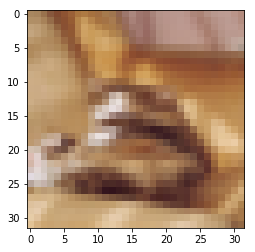

In [0]:
show_example(train_x, train_y, example_index = 241)

Label:  6


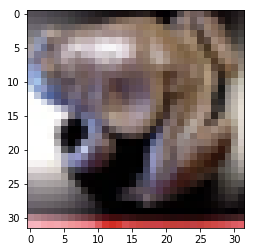

In [0]:
show_example(test_x, test_y, example_index = 162)

## Building the architecture of AlexNet

In [0]:
# Define some useful constants

image_shape = (32, 32, 3)
num_classes = 10
weight_decay = 5e-4
batch_size = 128
epochs = 200

In [0]:
# One hot encoding for labels

train_y = keras.utils.to_categorical(train_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

In [27]:
# Building the model

model = Sequential() # Baseline for our model, which means we will add layers one-by-one

# First convolutional layer

model.add(Conv2D(64, (3,3), 
                 padding = 'same',
                 input_shape = image_shape,
                 kernel_regularizer = regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# MaxPooling layer

model.add(MaxPooling2D(pool_size = (1,1)))
model.add(Dropout(0.3))

# Second convolutional layer

model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Second MaxPooling layer 

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Third Convolutional layer

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Fourth Convolutional layer

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Fifth Convolutional layer

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Third MaxPooling layer

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# First fully-connected layer

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Second fully-connected layer

model.add(Dense(512, kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))

# Output layer

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 64)        0         
__________

### Data augmentation and normalization

In [0]:
# Build ImageDataGenerator

data_generator = ImageDataGenerator(
    featurewise_center=False, 
    featurewise_std_normalization=False, 
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  
    vertical_flip=False)  

validation_generator = ImageDataGenerator()


In [0]:
# Define callback, that will reduce our learning rate when our validation data
# Loss function would reach plateau

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              min_lr = 1e-5,
                              min_delta=1e-4)

# Define callback for saving best model weight

best_weights_file = "weights_best_alexnet.hdf5"
checkpoint_callback = ModelCheckpoint(best_weights_file, 
                             monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Define optimizer

sgd_opt = optimizers.SGD(lr = 0.01, 
                           decay = 1e-6, 
                           momentum = 0.9, 
                           nesterov = True)


chechkpoint_list = [reduce_lr_callback, checkpoint_callback]

# Compile the model

model.compile(loss='categorical_crossentropy', optimizer=sgd_opt, metrics=['accuracy'])

Train the model

In [33]:
model.fit_generator(
    data_generator.flow(train_x, train_y, batch_size=batch_size),
    steps_per_epoch=train_x.shape[0] // batch_size,
    epochs=epochs,
    validation_data=validation_generator.flow(test_x, test_y, batch_size=batch_size),
    validation_steps = test_x.shape[0] // batch_size,
    callbacks=chechkpoint_list,
    verbose=1)


# TODO:
# Add more layer parameters
# Remove unnecessary multi dropouts

Epoch 1/200
390/390 [==============================] - 28s 73ms/step - loss: 1.7310 - acc: 0.6286 - val_loss: 1.7770 - val_acc: 0.6260

Epoch 00001: val_acc improved from -inf to 0.62600, saving model to weights_best_alexnet.hdf5
Epoch 2/200
390/390 [==============================] - 26s 65ms/step - loss: 1.6403 - acc: 0.6482 - val_loss: 1.5710 - val_acc: 0.6726

Epoch 00002: val_acc improved from 0.62600 to 0.67261, saving model to weights_best_alexnet.hdf5
Epoch 3/200
390/390 [==============================] - 26s 66ms/step - loss: 1.5591 - acc: 0.6633 - val_loss: 1.4192 - val_acc: 0.7168

Epoch 00003: val_acc improved from 0.67261 to 0.71677, saving model to weights_best_alexnet.hdf5
Epoch 4/200
390/390 [==============================] - 26s 67ms/step - loss: 1.4892 - acc: 0.6791 - val_loss: 1.3922 - val_acc: 0.7162

Epoch 00004: val_acc did not improve from 0.71677
Epoch 5/200
390/390 [==============================] - 26s 67ms/step - loss: 1.4301 - acc: 0.6916 - val_loss: 1.3409 -